In [1]:
import torch
import pickle
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
from utils import normalize_rgb, render_meshes, get_focalLength_from_fieldOfView, demo_color as color, print_distance_on_image, render_side_views, create_scene, MEAN_PARAMS, CACHE_DIR_MULTIHMR, SMPLX_DIR
from model import Model

torch.cuda.empty_cache()
device = torch.device('cuda')

# Functions from demo.py

In [2]:
def open_image(img_path, img_size, device=torch.device('cuda')):
    """ Open image at path, resize and pad """

    # Open and reshape
    img_pil = Image.open(img_path).convert('RGB')
    img_pil = ImageOps.contain(img_pil, (img_size,img_size)) # keep the same aspect ratio

    # Keep a copy for visualisations.
    img_pil_bis = ImageOps.pad(img_pil.copy(), size=(img_size,img_size), color=(255, 255, 255))
    img_pil = ImageOps.pad(img_pil, size=(img_size,img_size)) # pad with zero on the smallest side

    # Go to numpy 
    resize_img = np.asarray(img_pil)

    # Normalize and go to torch. MODIFIED TO NOT GOT TO TORCH
    resize_img = normalize_rgb(resize_img)
    x = np.expand_dims(resize_img, axis=0)
    return x, img_pil_bis

def load_model(model_name, device=torch.device('cuda')):
    """ Open a checkpoint, build Multi-HMR using saved arguments, load the model weigths. """
    # Model
    ckpt_path = os.path.join(CACHE_DIR_MULTIHMR, model_name+ '.pt')
    if not os.path.isfile(ckpt_path):
        os.makedirs(CACHE_DIR_MULTIHMR, exist_ok=True)
        print(f"{ckpt_path} not found...")
        print("It should be the first time you run the demo code")
        print("Downloading checkpoint from NAVER LABS Europe website...")
        
        try:
            os.system(f"wget -O {ckpt_path} https://download.europe.naverlabs.com/ComputerVision/MultiHMR/{model_name}.pt")
            print(f"Ckpt downloaded to {ckpt_path}")
        except:
            assert "Please contact fabien.baradel@naverlabs.com or open an issue on the github repo"

    # Load weights
    print("Loading model")
    ckpt = torch.load(ckpt_path, map_location=device)

    # Get arguments saved in the checkpoint to rebuild the model
    kwargs = {}
    for k,v in vars(ckpt['args']).items():
            kwargs[k] = v

    # Build the model.
    kwargs['type'] = ckpt['args'].train_return_type
    kwargs['img_size'] = ckpt['args'].img_size[0]
    model = Model(**kwargs).to(device)

    # Load weights into model.
    model.load_state_dict(ckpt['model_state_dict'], strict=False)
    print("Weights have been loaded")

    return model

def forward_model(model, input_image, camera_parameters,
                  det_thresh=0.3,
                  nms_kernel_size=1,
                 ):
        
    """ Make a forward pass on an input image and camera parameters. """
    
    # Forward the model.
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            humans = model(input_image, 
                           is_training=False, 
                           nms_kernel_size=int(nms_kernel_size),
                           det_thresh=det_thresh,
                           K=camera_parameters)

    return humans

def get_camera_parameters(img_size, fov=60, p_x=None, p_y=None, device=torch.device('cuda')):
    """ Given image size, fov and principal point coordinates, return K the camera parameter matrix"""
    K = torch.eye(3)
    # Get focal length.
    focal = get_focalLength_from_fieldOfView(fov=fov, img_size=img_size)
    K[0,0], K[1,1] = focal, focal

    # Set principal point
    if p_x is not None and p_y is not None:
            K[0,-1], K[1,-1] = p_x * img_size, p_y * img_size
    else:
            K[0,-1], K[1,-1] = img_size//2, img_size//2

    # Add batch dimension
    K = K.unsqueeze(0).to(device)
    return K

def overlay_human_meshes(humans, K, model, img_pil, unique_color=False):

    # Color of humans seen in the image.
    _color = [color[0] for _ in range(len(humans))] if unique_color else color
    
    # Get focal and princpt for rendering.
    focal = np.asarray([K[0,0,0].cpu().numpy(),K[0,1,1].cpu().numpy()])
    princpt = np.asarray([K[0,0,-1].cpu().numpy(),K[0,1,-1].cpu().numpy()])

    # Get the vertices produced by the model.
    verts_list = [humans[j]['verts_smplx'].cpu().numpy() for j in range(len(humans))]
    faces_list = [model.smpl_layer['neutral'].bm_x.faces for j in range(len(humans))]

    # Render the meshes onto the image.
    pred_rend_array = render_meshes(np.asarray(img_pil), 
            verts_list,
            faces_list,
            {'focal': focal, 'princpt': princpt},
            alpha=1.0,
            color=_color)

    return pred_rend_array, _color


# Load Model

In [3]:
model = load_model('multiHMR_896_L')

Loading model


Using cache found in /home/scott/.cache/torch/hub/facebookresearch_dinov2_main
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Weights have been loaded


# Load AGORA Dataset

In [4]:
img_size = model.img_size

train_x_path = "AGORA/train_0"
train_x = [] # images
train_y = [] # ground truth mesh vertices

with open("AGORA/SMPLX/train_0_withjv.pkl", "rb") as file:
    df = pd.read_pickle(file)
    for filename in os.listdir(train_x_path):
        file_path = os.path.join(train_x_path, filename)
        x, img_pil_nopad = open_image(file_path, img_size)
        train_x.append(x)
        print(x)
        y = df[df['imgPath'] == filename.replace("_1280x720", "")]
        train_y.append(np.array(y['gt_verts'][0]))

assert len(train_x) == len(train_y) == 1453 # Size of AGORA/train0



[[[[-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   ...
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]]

  [[-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]
   [-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]
   [-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]
   ...
   [-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]
   [-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]
   [-2.0357144 -2.0357144 -2.0357144 ... -2.0357144 -2.0357144
    -2.0357144]]

  [[-1.8044444 -1.8044444 -1.8044444 ...

# Align Humans

In [5]:
# remove extra humans based on detection score
from copy import copy
def align_humans(predictions, gts):
    predictions = copy(predictions)
    gts = copy(gts)

    aligned_preds = []
    aligned_gts = []
    for pred, gt in zip(predictions, gts):
        while len(pred) > len(gt):
            det_scores = [person['scores'] for person in pred]
            min_value = min(det_scores, key=lambda x: x.item())
            index = det_scores.index(min_value)
            pred = pred[:index] + pred[index+1:]
        while len(pred) < len(gt):
            gt = gt[:len(gt)-1]
            
        assert len(pred) == len(gt)
        aligned_preds.append(pred)
        aligned_gts.append(gt)

    assert len(aligned_preds) == len(aligned_gts)
    return aligned_preds, aligned_gts


# Vertices Loss function

In [6]:
def compute_loss(predictions, gts):
    # generate array of only vertex information
    pred_humans_with_only_vertices = []

    for humans in predictions:
        pred_vertices = []
        for human in humans:
            if torch.isnan(human['verts_smplx']).any():
                print("NaN detected in verts_smplx of prediction")
            pred_vertices.append(human['verts_smplx'])
        pred_humans_with_only_vertices.append(pred_vertices)
    
    criterion = torch.nn.L1Loss()

    # convert to tensors
    pred_humans_with_only_vertices = torch.stack([tensor for sublist in pred_humans_with_only_vertices for tensor in sublist])
    gts = torch.from_numpy(np.stack([item for sublist in gts for item in sublist]))

    pred_humans_with_only_vertices = pred_humans_with_only_vertices.to(device)
    gts = gts.to(device)

    # Check for NaN
    if torch.isnan(pred_humans_with_only_vertices).any():
        print("NaN detected in pred_humans_with_only_vertices after conversion")

    if torch.isnan(gts).any():
        print("NaN detected in gts after conversion")

    loss = criterion(pred_humans_with_only_vertices, gts)

    if torch.isnan(loss):
        print("NaN detected in the computed loss")

    return loss


## Test loss on small dataset

In [7]:
# p_x, p_y = None, None
# K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)

# small_output = []
# small_y = []
# for i in range(100):
#     input = torch.from_numpy(train_x[i]).to(device)
#     pred = forward_model(model, input, K,
#                         det_thresh=0.3,
#                         nms_kernel_size=1)
#     small_output.append(pred)
#     small_y.append(train_y[i])

# aligned_x, aligned_y = align_humans(small_output, small_y)
# print(compute_loss(aligned_x, aligned_y))


## Test loss on entire dataset with batching

In [8]:

p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
losses = []
batch_size = 5
num_batches = len(train_x) // batch_size
remainder = len(train_x) % batch_size

all_outputs = []

def process_batch(batch):
    batch_output = []
    for image in batch:
        input = torch.from_numpy(image).to(device)
        pred = forward_model(model, input, K,
                            det_thresh=0.3,
                            nms_kernel_size=1)
        batch_output.append(pred)
    return batch_output

for i in range(num_batches):
    if i == 1:
        break
    batch_x = train_x[i * batch_size: (i + 1) * batch_size]
    batch_y = train_y[i * batch_size: (i + 1) * batch_size]
    batch_output = process_batch(batch_x)
    batch_output, batch_y = align_humans(batch_output, batch_y)
    batch_loss = compute_loss(batch_output, batch_y)
    losses.append(batch_loss)
    torch.cuda.empty_cache()
    print(f"{(i+1)*100} of {len(train_x)}")

    all_outputs.append(batch_output)

if remainder > 0:
    remainder_x = train_x[num_batches * batch_size: ]
    remainder_y = train_y[num_batches * batch_size: ]
    remainder_output = process_batch(remainder_x)
    remainder_output, remainder_y = align_humans(remainder_output, remainder_y)
    remainder_loss = compute_loss(remainder_output, remainder_y)
    losses.append(remainder_loss)

    all_outputs.append(remainder_output)

total_loss = sum(losses)
average_loss = total_loss / len(train_x)
print(average_loss)



100 of 1453
tensor(0.0033, device='cuda:0', dtype=torch.float64)


In [9]:
outputs = []
for output in all_outputs:
    outputs = outputs + output
print(len(outputs))

8


In [10]:
with open("smaller_outputs_from_pretrained_multihmr.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [11]:
with open("single_output_from_pretrained_multihmr.pkl", "wb") as f:
    pickle.dump(outputs[0], f)

In [12]:
with open("5_output_from_pretrained_multihmr.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [13]:
with open("5_gt.pkl", "wb") as f:
    pickle.dump(train_y[:5], f)

# Training

In [17]:
def print_computation_graph(tensor, indent=0):
    if hasattr(tensor, 'grad_fn') and tensor.grad_fn is not None:
        print(' ' * indent, tensor.grad_fn)
        for next_tensor in tensor.grad_fn.next_functions:
            if next_tensor[0] is not None:
                print_computation_graph(next_tensor[0], indent + 2)

## Freeze Parameters

In [15]:
for name, param in model.named_parameters():
    if 'x_attention_head' not in name:
        param.requires_grad = False

## Optimize using vertex loss function

In [18]:
import torch
import torch.optim as optim
import random

torch.cuda.empty_cache()

#model = load_model('multiHMR_896_L')

p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
batch_size = 30
num_epochs = 10  
num_batches = len(train_x) // batch_size - 1 # we subtract 1 so that last batch is batch_size + remainder
remainder = len(train_x) % batch_size

optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

# Shuffle Data
combined = list(zip(train_x, train_y))
random.shuffle(combined)
train_x[:], train_y[:] = zip(*combined)


def process_batch(batch):
    batch_output = []
    for image in batch:
        input = torch.from_numpy(image).to(device)
        pred = model(input, 
                           is_training=True, 
                           nms_kernel_size=1,
                           det_thresh=0.4,
                           K=K)
        batch_output.append(pred)
    return batch_output

epoch_losses = []
batch_losses = []
for epoch in range(num_epochs):
    
    epoch_loss = 0
    for i in range(num_batches):
        if i != num_batches-1:
            batch_x = train_x[i * batch_size: (i + 1) * batch_size]
            batch_y = train_y[i * batch_size: (i + 1) * batch_size]
        else: # add remainder
            batch_x = train_x[i * batch_size:]
            batch_y = train_y[i * batch_size:]              
        
        print(f"Processing batch {i+1}/{num_batches} with {len(batch_x)} samples")

        optimizer.zero_grad()

        batch_output = process_batch(batch_x)
        batch_output, batch_y = align_humans(batch_output, batch_y)
        batch_loss = compute_loss(batch_output, batch_y)

        if torch.isnan(batch_loss):
            print(f"NaN detected in loss at batch {i+1}")

        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)

        optimizer.step()

        # Record loss
        batch_losses.append(batch_loss.item())
        epoch_loss += batch_loss.item()
        print(f"Epoch {epoch + 1}, Batch {(i + 1)}, Loss: {batch_loss.item()}")

        print_computation_graph(batch_loss)

        # Clean up
        del batch_x, batch_y, batch_output, batch_loss
        torch.cuda.empty_cache()

        
        
    average_epoch_loss = epoch_loss / (num_batches)
    epoch_losses.append(average_epoch_loss)
    print(f"Epoch {epoch + 1} Average Loss: {average_epoch_loss}")


torch.cuda.memory_allocated: 1.345494GB
torch.cuda.memory_reserved: 2.373047GB
torch.cuda.max_memory_reserved: 3.210938GB
Processing batch 1/47 with 30 samples
Epoch 1, Batch 1, Loss: 1.8143024530870435
Processing batch 2/47 with 30 samples
Epoch 1, Batch 2, Loss: 1.6137831405072802
Processing batch 3/47 with 30 samples


KeyboardInterrupt: 

In [ ]:
import time
model_path = f"models/fine_tuned_multihmr_{time.time()}.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Load 

In [ ]:
import pickle
import pandas
with open("Panda.pkl", 'rb') as f:
    data = pandas.read_pickle(f)

In [ ]:
data[0]['img_path']

'images/Det/01_University_Canteen/IMG_01_01.jpg'

# Graph

[3.813610006835285, 1.768482559415549, 1.57820879408102, 1.6076914021829143, 1.442643436563842, 1.3755304476323515, 1.4465870491595587, 1.262555459370189, 1.2485859122325893, 1.3553245006406494, 1.347962677831046, 1.341952047240508, 1.315669360373648, 1.2814767695198381, 1.2561975887269106, 1.2164321912331013, 1.2607287746567468, 1.2629204931022477, 1.2609047500258446, 1.288043760114036, 1.1843337627822357, 1.3008310814550228, 1.2329859904467722, 1.2378246429930075, 1.2630490938858159, 1.3022987604258283, 1.2910250735610282, 1.31254395708739, 1.2694183994802866, 1.3084168698755425, 1.2180157235587503, 1.2699897709940675, 1.2767625885240277, 1.2899080429376284, 1.30514221500721, 1.2386183014541083, 1.237856721346173, 1.301260882256457, 1.2399907504195407, 1.2597224218847016, 1.2542895869223774, 1.27066389980921, 1.2604874146652665, 1.3278703753588408, 1.2128940815033589, 1.2432951189073598, 1.2618496409055975, 1.3029941812843078, 1.1864565806576717, 1.292365432041986, 1.2743155970084383

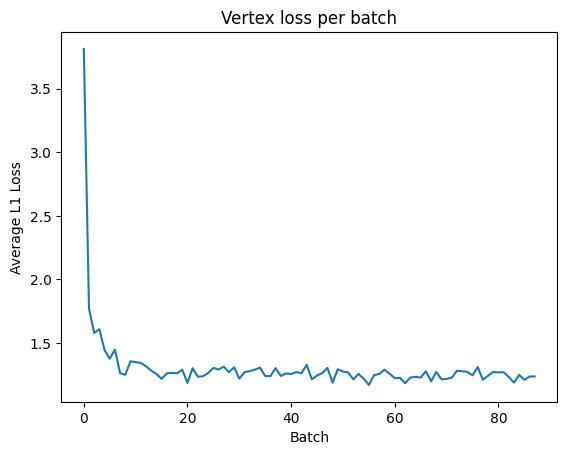

In [ ]:
import matplotlib.pyplot as plt
import time

print(batch_losses)

plt.title("Vertex loss per batch")
plt.xlabel("Batch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(batch_losses)), batch_losses)

plt.savefig(f"Visualizations/multihmr_loss_per_batch_{time.time()}.png")

In [ ]:
import matplotlib.pyplot as plt

print(epoch_losses)

plt.title("Vertex Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(epoch_losses)), epoch_losses)

plt.savefig(f"Visualizations/multihmr_loss_per_epoch_{time.time()}.png")

NameError: name 'epoch_losses' is not defined